# Logistic Regression

#### Consider binary output and denote the probability of an output of 1 as: $p = P(Y=1)$ for $0 < p < 1$

#### Then the odd of this probability is: $\frac{p}{1-p}$ .

#### Let the base of the logarithm be $b=e$, the log-odd then is: $logit(p) = ln(\frac{p}{1-p})$

#### Assume a linear relationship with predictor variables: $ln(\frac{p}{1-p}) = w_{0} + w_{1}x_{1} + w_{2}x_{2} .. \Leftrightarrow  \frac{p}{1-p} = e^{w^{T}x}$

#### Determine probability of output 1 as: $p = \frac{1}{1 + e^{-w^{T}x}}$

#### With a given linear model $z = w^{T}x$ this formula represents the sigmoid function: $\sigma(z)=\frac{e^{z}}{e^{z} - 1} =\frac{1}{1+e^{-z}}$

Note: This was simplified. The full linear model still has a bias such that: $z = w_0 + w^{T}x = w_{0} + \sum_{i=1}^{m}w_{i}x_{i}$. To keep things clean it was not considered in this example

#### Goal: find best parameters $w0, w1, w2, ...$ of this model (model fitting)

#### The logistic regression model output is $\hat{y} = \sigma(z) = \sigma(w^{T}x)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1337)

#### Plot the sigmoid function

In [2]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

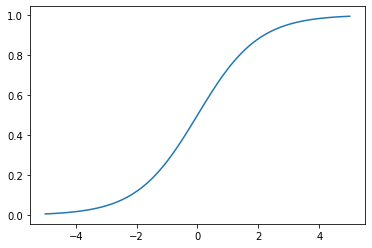

In [3]:
x_val = np.linspace(-5,5,100)
plt.plot(x_val,sigmoid(x_val))
plt.show()

#### Run an example model

In [4]:
num_samples = 200 # number N of samples. We will calculate N different z values, one for each sample
num_dim = 2 # model dimension (2d data here)

In [5]:
x = np.random.randn(num_samples,num_dim) #some data of any form. Here: noise
x.shape
# Note that we didn't add the bias w_0 here.
# It can be easily done by adding one column to the left of x and initalize it with a value, e.g. ones!

(200, 2)

In [6]:
w = np.random.randn(num_dim)
w.shape,w

((2,), array([-0.37523099,  0.80430086]))

In [7]:
z = x.dot(w)
z.shape

(200,)

#### Binary classification example

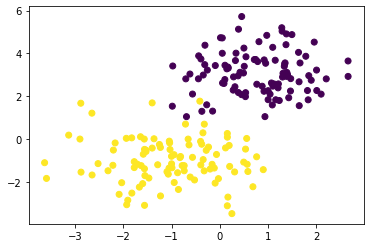

In [8]:
# make some new data and weights
x = np.random.randn(num_samples,num_dim) #some data of any form. Here: noise
w = np.random.randn(num_dim)

# shape our data to something binary classifiable. Here: two clouds
x[:int(num_samples/2)] = x[:int(num_samples/2)] + [1,3]
x[int(num_samples/2):] = x[int(num_samples/2):] + [-1,-1]

# Create targets/labels/real classes/ground truth however you like to call it :)
t = np.array([0]*int(num_samples/2) + [1]*int(num_samples/2))

# plot
plt.scatter(x[:,0],x[:,1],c=t)

In [9]:
# Generate model output predictions (remember our weights are still random initialized and not trained)
z = x.dot(w)
y = sigmoid(z)

# Look at some predictions
y[0:20]

array([0.75725893, 0.92308937, 0.91637066, 0.62480896, 0.84410344,
       0.93483018, 0.91327288, 0.84967773, 0.90274976, 0.84117424,
       0.91132058, 0.84959823, 0.47164741, 0.70184994, 0.80834556,
       0.94924071, 0.84866335, 0.48478826, 0.76699216, 0.85261655])

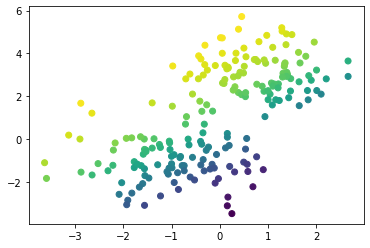

In [10]:
# Let's plot it
plt.scatter(x[:,0],x[:,1],c=y)

Since the sigmoid gives us class probabilites we didn't decide on the classes yet.

Let's add a decision boundary that sharply cuts this data into two

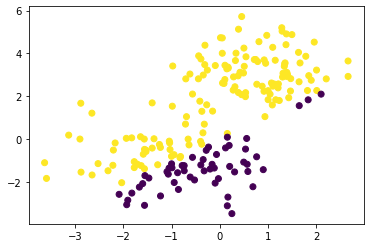

In [11]:
thresh = 0.5
predicted_classes = np.copy(y)
predicted_classes[predicted_classes<=thresh]=0
predicted_classes[predicted_classes>thresh]=1

#Plot again
plt.scatter(x[:,0],x[:,1],c=predicted_classes)

This isn't the correct classification (in most cases, unless the random initialization got lucky)

So we have to calculate the loss of this set of predictions and optimize the weights according to it

#### Cross entropy loss

based on negative log-likelihood $\Rightarrow$ minimizing this loss function is equivalent to maximum log-likelihood.

With $\hat{y}_k \in (\hat{y},1-\hat{y})$ as the model classification and $t_k \in (l,1-l)$ as the real class label, the cross entropy loss for binary classification is:

### $J := J(\hat{y}_k,t_k) = -\sum_k t_k log(\hat{y}_k) = -l~log(\hat{y}) - (1-l) log(1-\hat{y})$

Note that if the true label is one ($l=1$) then $J = -log(\hat{y})$

And if it is zero ($l=0$) then $J = -log(1-\hat{y})$

In [12]:
#Additional:
# With N samples (batch learning) you get:
### $J(w) = -\frac{1}{N}\sum_n\sum_k t_{nk} log(\hat{y}_{nk}) = -\frac{1}{N} \sum_n (l_{n} log(\hat{y}_{n}) + (1 - l_{n}) log(1 - \hat{y}_{n}))$

In [13]:
def cross_entropy(targets,predictions):
    error = 0
    for i in range(targets.shape[0]):
        if targets[i] == 1:
            error = error - np.log(predictions[i])
        if targets[i] == 0:
            error = error - np.log(1 - predictions[i])
    return error

In [14]:
print(cross_entropy(targets=t,predictions=y))

256.22124996719907


#### Updating weights with gradient descent

### $w^{(\tau)}_i = w^{(\tau-1)}_i - \eta \frac{\partial J(w)}{\partial w^{(\tau-1)}_i}$

First consider the case of the label being one ($l=1$). Then

### $J(w) = -log(\hat{y}) = -log(\sigma(w^{T}x)) = -log(\sigma(w_{0}+ w_{1}x_{1} + w_{2}x_{2} .. ))$

The derivative of the sigmoid is:

### $\frac{\partial}{\partial z} \sigma(z) = \sigma(z) (1 - \sigma(z))$

The derivative of the cost function then is: 

### $\frac{\partial J(w)}{\partial w_i} = \frac{\partial J(w)}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial z}\frac{\partial z}{\partial w_i} =~...~= (\hat{y}-l)x_i$

In [15]:
learning_rate = 0.1
num_steps = 50

In [16]:
print('cross entropy before: {}'.format(cross_entropy(targets=t,predictions=y)))
for i in range(num_steps):
    # gradient descent
    w = w - learning_rate*x.T.dot(y-t)
    # next time step/ calculate model prediction
    y = sigmoid(x.dot(w))
    print('cross entropy after step {} = {}'.format(i+1,cross_entropy(targets=t,predictions=y)))

cross entropy before: 256.22124996719907
cross entropy after step 1 = 185.27557982821784
cross entropy after step 2 = 171.9950162001874
cross entropy after step 3 = 158.72236212281658
cross entropy after step 4 = 145.53002091334633
cross entropy after step 5 = 133.34349914734682
cross entropy after step 6 = 124.11438331702195
cross entropy after step 7 = 116.12038299939782
cross entropy after step 8 = 108.6315215195595
cross entropy after step 9 = 102.90625450686522
cross entropy after step 10 = 98.91484820646137
cross entropy after step 11 = 95.33050277460872
cross entropy after step 12 = 91.85203447599227
cross entropy after step 13 = 88.43191332003076
cross entropy after step 14 = 85.07037738022952
cross entropy after step 15 = 81.77915522267585
cross entropy after step 16 = 78.57420746898282
cross entropy after step 17 = 75.47402142277065
cross entropy after step 18 = 72.49889896376676
cross entropy after step 19 = 69.67020726403814
cross entropy after step 20 = 67.00903728603784
c

#### Plot results

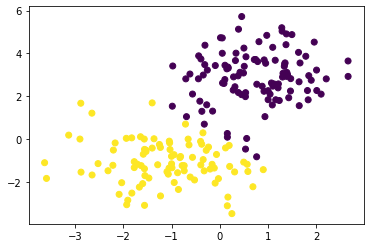

In [17]:
thresh = 0.5
predicted_classes = np.copy(y)
predicted_classes[predicted_classes<=thresh]=0
predicted_classes[predicted_classes>thresh]=1

#Plot again
plt.scatter(x[:,0],x[:,1],c=predicted_classes)

HOOORAY!

### Further reading;

https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc